# Import

In [45]:
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import re
import contractions
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import collections
import math
import pickle


import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
STOPWORDS = set(stopwords.words("english"))

import torchtext
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
import torch.nn.utils.rnn as rnn_utils
from torch.utils.data import Dataset, DataLoader, random_split 
from torch import nn
import torch 

from tqdm import tqdm

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print('device = ', DEVICE)

device =  cuda


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nguye\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#  Hyperparams

In [54]:
ROOT = os.getcwd()
DATASET_PATH = os.path.join(ROOT, 'dataset', 'amazon_full' )
ALL_DF_CSV = os.path.join(DATASET_PATH, 'all_df.csv')

OUTPUT_PATH = os.path.join(ROOT, 'output', 'bert')

if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)

BATCH_SIZE = 64
SAMPLE_SIZE = 0.01

# Load the whole dataset and truncate it (for experiments)

In [3]:
# train_txt = bz2.BZ2File(os.path.join(datasetpath, 'train.ft.txt.bz2'))
# train_txt = bz2.BZ2File('/content/drive/MyDrive/UB/Sem 2/DL/DL FINAL Project/train.ft.txt.bz2')

# train_txt = bz2.BZ2File(DATASET_PATH)
# train_lines = train_txt.readlines()

In [29]:
train_df = pd.read_csv(train_datapath, names = ["review", "title","text"])
train_df = train_df.sample(frac = SAMPLE_SIZE)
train_df.reset_index(inplace = True, drop = True)
train_df.head()
# print(train_df.shape)
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
train_df['review'] = train_df['review'].map(label_map)
print(train_df.shape)
print(train_df['review'].value_counts())
train_df.head()

(30000, 3)
review
2    6079
1    6016
4    6002
0    5989
3    5914
Name: count, dtype: int64


,review,title,text
0,1,"HM, well OK","Hm, I was definitely disappointed. This book i..."
1,2,It's Been a While...,It took me a while to fall in love with this a...
2,0,Zero Stars,WORSTMOVIEEVER!Not a single laugh or other red...
3,0,slavery was fun for the slaves,"In the very first couple of lines, i knew some..."
4,3,Color is the only way to go,COMBAT! THE BEST OF THE COLOR EPSODES is the o...


In [32]:
test_df = pd.read_csv(train_datapath, names = ["review", "title","text"])
test_df = test_df.sample(frac = SAMPLE_SIZE)
test_df.reset_index(inplace = True, drop = True)
test_df.head()
label_map = {
    1: 0,
    2: 1,
    3: 2,
    4: 3,
    5: 4,
}
test_df['review'] = test_df['review'].map(label_map)
test_df.reset_index(inplace=True, drop = True)
print(test_df['review'].value_counts())
print(test_df.shape)
test_df.head()

review
4    6055
3    6051
1    6045
0    5994
2    5855
Name: count, dtype: int64
(30000, 3)


,review,title,text
0,3,SIMPLY SMASHING,EVEN THOUGH THEY DISBANDED THE PUMPKINS STILL ...
1,0,Self limited market share,I bought all of season 1 for my iPod. I'm only...
2,0,The next failure!,His voice is so terrible and just can't stand ...
3,0,Unreadable,I had to read this book for a book group. I fo...
4,1,What's it for?,This pan is really too small to be useful. And...


# Sample size

In [26]:
# #only tkae 10% of this dataset
# LIMIT = int(1 * len(train_lines))
# print('limit = ', LIMIT)

# truncated_train_lines = train_lines[:LIMIT]

# TRAIN_RATIO = 0.9
# train_len = int(len(truncated_train_lines) * TRAIN_RATIO)

# train_array = [x.decode('utf-8') for x in truncated_train_lines[:train_len]]
# test_array = [x.decode('utf-8') for x in truncated_train_lines[train_len:]]

# #apply limit to a big dataset
# train_array = train_array[:LIMIT]

# print('train len = ', len(train_array))
# print('test len = ', len(test_array))

# Clean text

In [27]:
# Cleaning Text

def remove_urls(text):
    #if there's link in text, like www.something.com, https://www.something.com,
    # replace it with the <url> token
    pattern = re.compile(r'https?://\S+|www\.\S+')
    text = pattern.sub(' ', text)
    return text

def remove_digits(text):
    return re.sub("\d", ' ', text)

def remove_punctation(text):
    return re.sub(r'[^\w\s]',' ',text)

def expand_contraction(text):
    return contractions.fix(text)

def remove_stopwords(text):
    return ' '.join([word for word in text.split(' ') if word not in STOPWORDS])

def clean_text(text):
    '''
    extract feature and label from line and process the text
    @params:
        text: string, format: __label__2 some text.
    @return:
        feature: string
        label: int, 0: bad review, 1 good review
    '''
    #Each line has format: __label__2 some text.
    #The first part is label, the rest is text feature
    #lower case the features
    text = text.lower()
    #start cleaning

    #remove urls in text
    text = remove_urls(text)
    #remove digits
    text = remove_digits(text)
    # # #expand contractions
    text = expand_contraction(text)
    # # #remove punctuations
    text = remove_punctation(text)
    # # #remove stop words
    text = remove_stopwords(text)

    #__label__1 = 0: bad review, __label__2 = 1,good review
    text = ' '.join(t for t in text.split() if t != '')
    return text.strip()

test_string = '''This is a test string. Here are some special characters: &,#,$. How about some punctuations? !@#$%^&*()_+=-`~{[]}|:;'<,>.?/"|https://www.example.com'''

clean_text(test_string)

'test string special characters punctuations _'

In [36]:
eda_df = train_df.copy()
eda_df['text'] = eda_df['text'].apply(lambda s: clean_text(s))
eda_df['lengths'] = eda_df['text'].apply(lambda s: len(s))
MAX_LENGTH = eda_df['lengths'].max()
print('max length = ', MAX_LENGTH)

# Stats
eda_df.describe()

max length =  834


,review,lengths
count,30000.000000,30000.000000
mean,1.997467,252.702700
std,1.412985,149.236198
min,0.000000,22.000000
25%,1.000000,127.000000
50%,2.000000,222.000000
75%,3.000000,353.000000
max,4.000000,834.000000


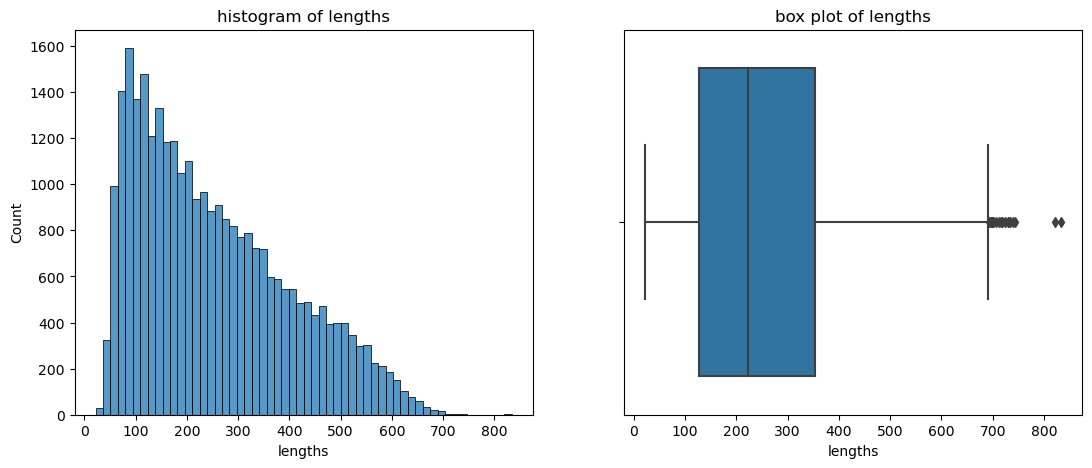

In [40]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.histplot(eda_df, x = 'lengths', ax = ax1)
ax1.set_title('histogram of lengths')
sns.boxplot(eda_df, x = 'lengths', ax = ax2)
ax2.set_title('box plot of lengths')
plt.show()

# A little EDA

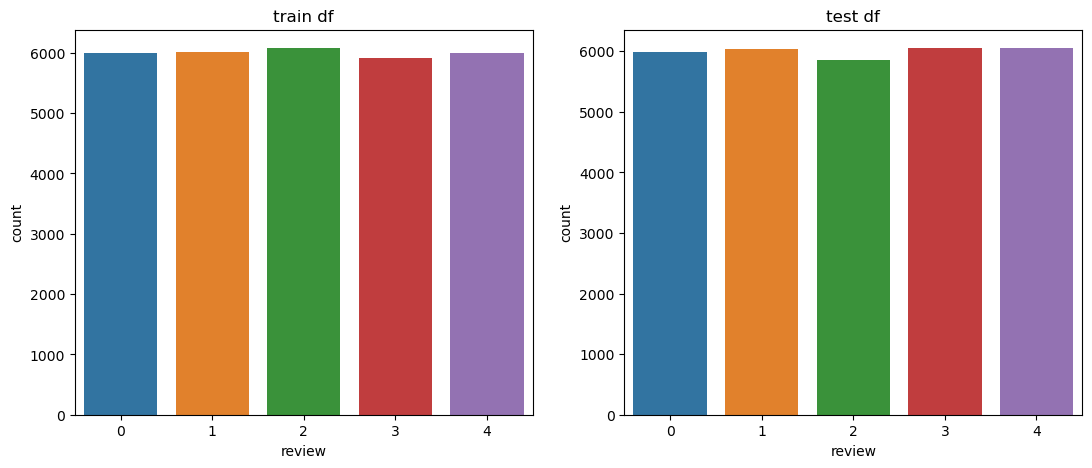

In [38]:
# bad_reviews = eda_df.loc[eda_df['review'] == 1]['text'].apply(lambda s: len(s)).values
# good_reviews = eda_df.loc[eda_df['review'] == 2]['text'].apply(lambda s: len(s)).values
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(13,5))
sns.countplot(train_df, x = 'review', ax = ax1)
ax1.set_title('train df')
sns.countplot(test_df, x = 'review', ax = ax2)
ax2.set_title('test df')
plt.show()

# Prepare data

In [41]:
tokenizer = torchtext.data.utils.get_tokenizer("basic_english")

def build_array(X, maxlength = 2000):
    X_tokens = []
    X_lengths = []
    for text in tqdm(X):
        tokens = tokenizer(text)[:maxlength]
        X_tokens.append(tokens)
        X_lengths.append(len(tokens))

    return X_tokens, X_lengths


def get_ids(tokens, vocab):
    ids = vocab.lookup_indices(tokens)
    return torch.tensor(ids)

def build_train_test_data(feature_train, label_train, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), vocab, pad_id


def build_train_test_data_v2(feature_train, label_train, feature_test, label_test, min_vocab_freq = 2, **kwargs):
    train_tokens, train_lengths = build_array(feature_train)
    test_tokens, test_lengths = build_array(feature_test)

    unk_token = '<unk>'
    pad_token = '<pad>'
    special_tokens = [unk_token, pad_token]

    vocab = torchtext.vocab.build_vocab_from_iterator(
        train_tokens + test_tokens,
        min_freq=min_vocab_freq,
        specials=special_tokens,
    )

    unk_id = vocab[unk_token]
    pad_id = vocab[unk_token]

    vocab.set_default_index(unk_id)

    print('vocab len = ', len(vocab))

    def convert_to_ids_labels_lengths(token_list, labels, lengths):
        id_list = []

        for tokens in tqdm(token_list):
            ids = get_ids(tokens, vocab)
            id_list.append(ids)

        #convert y to tensor
        labels = torch.tensor(labels)
        #convert X lengths to tensor
        lengths = torch.tensor(lengths)

        return id_list, labels, lengths

    train_ids, train_y, train_lengths = convert_to_ids_labels_lengths(train_tokens, label_train, train_lengths)
    test_ids, test_y, test_lengths = convert_to_ids_labels_lengths(test_tokens, label_test, test_lengths)

    return (train_tokens, train_ids, train_y, train_lengths), \
            (test_tokens, test_ids, test_y, test_lengths),\
            vocab, pad_id

In [49]:
print('train df shape = ', train_df.shape)
print('test df shape = ', test_df.shape)

all_df = pd.concat([train_df, test_df])
print('all df shape = ', all_df.shape)


X_array = all_df['text'].apply(lambda s: clean_text(s)).values
y_array = all_df['review'].values

(train_tokens, train_ids, train_y, train_lengths) ,vocab, pad_id = build_train_test_data(X_array, y_array)

train_ids = pad_sequence(train_ids, batch_first=True, padding_value=pad_id)

print('ids shape = ', train_ids.shape )
print('y values = ', set(train_y.tolist()) )
print('y shape = ', train_y.shape )
print('lengths shape = ', train_lengths.shape)

# print('test')
# print('ids shape = ', test_ids.shape )
# print('y values = ', set(test_y.tolist()) )
# print('y shape = ', test_y.shape )
# print('lengths shape = ', test_lengths.shape)

train df shape =  (30000, 3)
test df shape =  (30000, 3)
all df shape =  (60000, 3)


100%|██████████| 60000/60000 [00:01<00:00, 49546.96it/s]


vocab len =  42434


100%|██████████| 60000/60000 [00:01<00:00, 58685.29it/s]


ids shape =  torch.Size([60000, 146])
y values =  {0, 1, 2, 3, 4}
y shape =  torch.Size([60000])
lengths shape =  torch.Size([60000])


In [43]:
for label, token, id, length in zip(train_y[:1], train_tokens[:1], train_ids[:1], train_lengths[:1]):
    print(f'label={label}\ntokens={token}\nlength={length}\nids={id}')

print('vocab len = ', len(vocab))

label=1
tokens=['hm', 'definitely', 'disappointed', 'book', 'well', 'written', 'make', 'maticulous', 'notes', 'going', 'catch', 'important', 'stuff', 'also', 'take', 'account', 'difference', 'babies', 'personalities', 'lumps', 'difficult', 'ones', 'stubborn', 'tells', 'work', 'stubborness', 'first', 'case', 'narrow', 'view', 'hannah', 'stubborn', 'personality', 'makes', 'tooooo', 'interested', 'rest', 'world', 'worry', 'pooping', 'potty', 'even', 'spend', 'day', 'working', 'enjoyed', 'sitting', 'potty', 'time', 'time', 'get', 'every', 'two', 'seconds', 'anyway', 'would', 'probably', 'say', 'ready', 'yet', 'maybe', 'true', 'hey', 'said', 'someone', 'wants', 'potty', 'train', 'month', 'old', 'less', 'follow', 'principles', 'well', 'good', 'luck']
length=76
ids=tensor([14279,   212,   116,     2,    12,   123,    38,     0,  1190,    71,
         1495,   505,   252,    19,   103,  1314,   789,  2291,  4411, 24609,
          298,   312,  8422,   942,    30, 30954,    15,   200,  2754,   67

# Save csv

In [60]:
print('saving processed df to : ', ALL_DF_CSV)
all_df.to_csv(ALL_DF_CSV, index=False)

saving processed df to :  e:\ML\NLP\UB DL\final\dataset\amazon_full\all_df.csv
